# **Machine Learning Lab 4EII - IA course**

## 1- **Introduction**

This lab aim at using **auto encoders** for diffrent applications such as image compression and image de-noising. The auto-encoder can be based on neural networks with dense layers or convolutional neural networks:  

In this lab you will learn to:
* Build you own auto-encoder based on NN and CNN.
* Apply the auto-encoder for image denoising and compression.
* Build a variational auto-encoder 


## 2- **Module importation**
Import some useful and common python modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import progressbar
import time

## 3- **Download and study the the MNIST dataset**



### 3.a - Download the MNIST dataset

MNIST dataset contains 70000 images of handwritten digits from 0 to 9. The dataset contains images of size 28x28 pixels and the corresponding labels

In [2]:
mnist = fetch_openml('mnist_784') #You can also use and test mnist_784 or Fashion-MNIST dataset  

### 3.b - Create a class structure to save and analyse the dataset

In [3]:
def computeentropy(image):
  lensig=image.size
  symset=list(set(image))
  numsym=len(symset)
  propab=[np.size(image[image==i])/(1.0*lensig) for i in symset]
  ent=np.sum([p*np.log2(1.0/p) for p in propab])
  return ent;

class Digit:
  def __init__(self, data, target):
    self.width      = int(np.sqrt((len(data))))
    self.target     = target;
    self.image      = data;
    
    self.features   = {
                        'var'        :0.0, 'std'        :0.0,
                        'mean'       :0.0, 'entropy'    :0.0,
                      }
    self.computeFeatures()
    
  def computeFeatures(self):
    self.features['var'] = round(np.var(self.image),2)
    self.features['std'] = round(np.std(self.image),2)
    self.features['mean'] = round(np.mean(self.image),2)
    self.features['entropy'] = round(computeentropy(self.image),2)

  def print(self):
    print("Digit target: " + str(self.target))
    print("Digit target size: "+ str(self.width)  + "x" +str(self.width) + 
          '| mean : ' + str(self.features['mean']) +
          '| var : ' + str(self.features['var']) + 
          '| std :' + str(self.features['std']) + 
          '| entropy :' + str(self.features['entropy']))
    print("Digit image:")
    plt.figure()
    plt.gray()
    plt.matshow(self.image.reshape(self.width, self.width)) 
    plt.savefig(str(self.target)+'.png', bbox_inches='tight')
    plt.show() 
  def getWidth(self):
    return self.width;


class Dataset:    
  def __init__(self, data, size=0, nb_classes=10):  
    self.length = int((len(data['data'])))
    if size > 0 and size <  self.length:
      self.length = size;
    else:
      size = self.length;  

    self.targets  = data['target'][0:size]
    self.data = data['data'][0:size];
    self.digits       = [];
    self.nb_classes = nb_classes; 
    self.createDigits()
    self.X_train = []; 
    self.X_test = []; 
    self.y_train = []; 
    self.y_test = [];  
  
  def printInfo(self):
    from collections import Counter
    
    c = Counter(self.targets)
    info = "Dataset size " + str(self.length)
    key_value = {} 
    for i in sorted(c.keys()):
      key_value[i] = c[i];
     
    plt.bar(key_value.keys(), key_value.values());
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of MNIST dataset labels')
    ax = plt.axes()        
    ax.grid(which='major', axis='y')
    plt.show()
    return info
  
  def createDigits(self):
    bar = progressbar.ProgressBar(maxval=self.length).start()
    for i in range(self.length):
        self.digits.append(Digit(self.data[i], self.targets[i]))
        bar.update(i+1);

  def separate_train_test(self, test_size_ratio):
    from sklearn.model_selection import train_test_split 
    import keras

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.targets, test_size=test_size_ratio)
    # data normalization   
    self.X_train = self.X_train.astype('float32')/255;
    self.X_test  = self.X_test.astype('float32')/255;

    
    print('Size of training set : ' + str(len(self.y_train)) + ' / ' + str(len(self.data)));
    print('Size of testing set : ' + str(len(self.y_test))+ ' / ' + str(len(self.data)));
    self.X_train  = self.X_train.reshape(len(self.X_train), self.digits[0].getWidth()*self.digits[0].getWidth())  # reshape input from (28,28) to 784
    self.X_test   = self.X_test.reshape(len(self.X_test), self.digits[0].width*self.digits[0].width)
    
   
    self.Y_train = keras.utils.to_categorical(self.y_train, self.nb_classes)
    self.Y_test = keras.utils.to_categorical(self.y_test, self.nb_classes)
  
  def reshapeinImage(self):
    width = self.digits[0].width; 
    self.X_trainIm = self.X_train.reshape(self.X_train.shape[0], width, width, 1)
    self.X_testIm  = self.X_test.reshape(self.X_test.shape[0], width, width, 1)
    
  def adddNoise(self, intensity=1):
    self.X_trainIm_noisy = self.X_trainIm + intensity * np.random.normal(loc=0.0, scale=1.0, size=self.X_trainIm.shape) 
    self.X_testIm_noisy = self.X_testIm + intensity * np.random.normal(loc=0.0, scale=1.0, size=self.X_testIm.shape) 

    self.X_trainIm_noisy = np.clip(self.X_trainIm_noisy, 0., 1.)
    self.X_testIm_noisy = np.clip(self.X_testIm_noisy, 0., 1.)



  def display_train_test(self):
    from collections import Counter

    test = Counter(self.y_test)
    train = Counter(self.y_train)
    info = "Dataset size " + str(self.length) 
    
    key_value_train = {};
    key_value_test = {};
    
    for i in sorted(test.keys()):
      key_value_test[i] = test[i];
    for i in sorted(train.keys()):
      key_value_train[i] = train[i];

    p1 = plt.bar(key_value_train.keys(), key_value_train.values(), width=0.5);
    p2 = plt.bar( key_value_test.keys(), key_value_test.values(), width=0.5, bottom=list(key_value_train.values()) ); 
    
    plt.legend((p1[0], p2[0]), ('Training set', 'Test set'), loc='lower left')
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of training and testing sets')
    ax = plt.axes()        
    ax.grid(which='major', axis='y')
    plt.show();    

### 3.b - Load the MNIST dataset in Dataset class and analyse it: 
1.   Load the dataset in Dataset class 

*samples* is the number of considered samples (sub-set) over 700000 of MNIST dataset, it enables faster training and testing



In [4]:
samples = 0; # All pictures 
training_set  = Dataset(mnist, samples) 

2.   Display some digist with corresponding features  

Digit target: 5
Digit target size: 28x28| mean : 35.11| var : 6343.94| std :79.65| entropy :1.83
Digit image:


<Figure size 432x288 with 0 Axes>

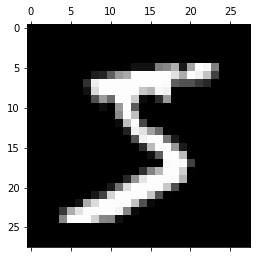

Digit target: 0
Digit target size: 28x28| mean : 39.66| var : 7037.06| std :83.89| entropy :1.92
Digit image:


<Figure size 432x288 with 0 Axes>

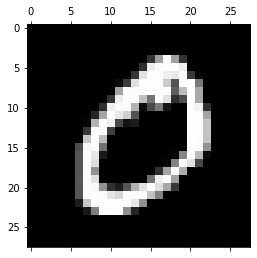

Digit target: 4
Digit target size: 28x28| mean : 24.8| var : 4300.7| std :65.58| entropy :1.46
Digit image:


<Figure size 432x288 with 0 Axes>

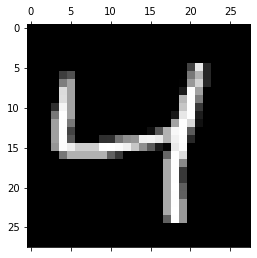

Digit target: 1
Digit target size: 28x28| mean : 21.86| var : 4366.42| std :66.08| entropy :1.1
Digit image:


<Figure size 432x288 with 0 Axes>

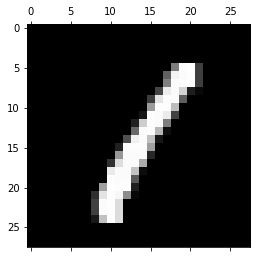

Digit target: 9
Digit target size: 28x28| mean : 29.61| var : 5531.09| std :74.37| entropy :1.61
Digit image:


<Figure size 432x288 with 0 Axes>

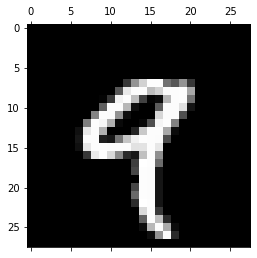

Digit target: 2
Digit target size: 28x28| mean : 37.76| var : 6577.97| std :81.1| entropy :2.11
Digit image:


<Figure size 432x288 with 0 Axes>

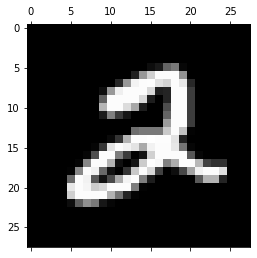

Digit target: 1
Digit target size: 28x28| mean : 22.51| var : 4602.49| std :67.84| entropy :0.94
Digit image:


<Figure size 432x288 with 0 Axes>

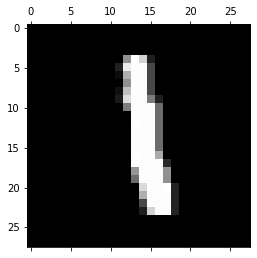

Digit target: 3
Digit target size: 28x28| mean : 45.75| var : 8102.99| std :90.02| entropy :1.99
Digit image:


<Figure size 432x288 with 0 Axes>

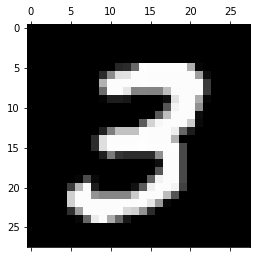

Digit target: 1
Digit target size: 28x28| mean : 13.87| var : 2768.36| std :52.62| entropy :0.81
Digit image:


<Figure size 432x288 with 0 Axes>

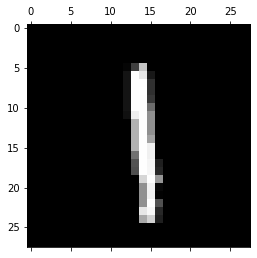

Digit target: 4
Digit target size: 28x28| mean : 27.94| var : 5120.58| std :71.56| entropy :1.59
Digit image:


<Figure size 432x288 with 0 Axes>

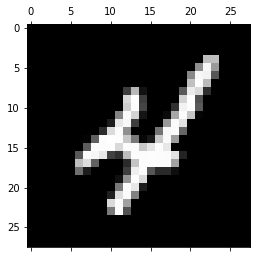

In [5]:
samples_to_diplay = 10;
for i in range(samples_to_diplay):
  training_set.digits[i].print()

3.   Display digits repartitions with *printInfo* function of *Dataset* class

*   Is the dataset well balanced ?





<ipython-input-3-6e5e4f8cbc6c>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


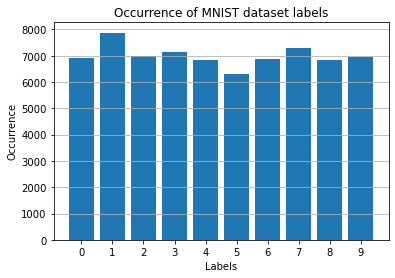

'Dataset size 70000'

In [6]:
training_set.printInfo()

## 4 - **Dataset preparation**


> The MNIST dataset is split to training and testing sets with the corresponding labels



### 4.a - Split the the MNIST dataset in training and testing sets 

*   Use *separate_train_test* function with a test set split ratio as parameter 
*   The test and train sets will be loaded in X_train and X_test lists and the corresponding labels in y_train and y_test lists. 




In [7]:
test_ratio = 0.25;
training_set.separate_train_test(test_ratio)

Size of training set : 52500 / 70000
Size of testing set : 17500 / 70000


### 4.b - Display the repartition of the digits 

*   Use  *display_train_test* function to illustrate the digits' repartition 
*   Check whether the repartition ratio is correct 



<ipython-input-3-6e5e4f8cbc6c>:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


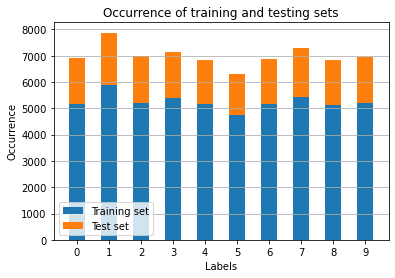

In [8]:
training_set.display_train_test()

## 5 - **Build an auto-encoder with dense layers**


### 5.a - Build an auto-encoder with one dense layer


> Import keras module 

In [9]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

> In this section you will 

1) bluid an auto-encoder with one dense layer 

2) Train the auto-encodeur 

In [10]:
original_dim = 784
latent_dim = 32

epochs=80
batch_size=256

input_img = Input(shape=(original_dim,))

encoder_layer = Dense(latent_dim, activation='relu')
encoded = encoder_layer(input_img)

decoder_layer = Dense(original_dim, activation='sigmoid') 
decoded = decoder_layer(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # you can also use MSE loss function 

encoder = Model(input_img, encoded)

encoded_input = Input(shape=(latent_dim,))
decoder = Model(encoded_input, decoder_layer(encoded_input))


autoencoder.summary()

logsNN1 = autoencoder.fit(training_set.X_train, training_set.X_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(training_set.X_test, training_set.X_test))#TO DO train the model 


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
206/206 [==============================] - 3s 9ms/step - loss: 0.3987 - val_loss: 0.1974
Epoch 2/80
206/206 [==============================] - 1s 7ms/step - loss: 0.1872 - val_loss: 0.1621
Epoch 3/80
206/206 [==============================] - 1s 6ms/step - loss: 0.1563 - val_loss: 0.1415
Epoch 4/80
206/206 [==============================] - 1s 6ms/step - loss: 0.1384 - val_

Epoch 75/80
206/206 [==============================] - 1s 6ms/step - loss: 0.0920 - val_loss: 0.0927
Epoch 76/80
206/206 [==============================] - 1s 6ms/step - loss: 0.0922 - val_loss: 0.0928
Epoch 77/80
206/206 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0927
Epoch 78/80
206/206 [==============================] - 1s 6ms/step - loss: 0.0923 - val_loss: 0.0927
Epoch 79/80
206/206 [==============================] - 1s 6ms/step - loss: 0.0924 - val_loss: 0.0927
Epoch 80/80
206/206 [==============================] - 1s 6ms/step - loss: 0.0922 - val_loss: 0.0927


> Draw the evolution of the loss function during the training on training set and testing set 

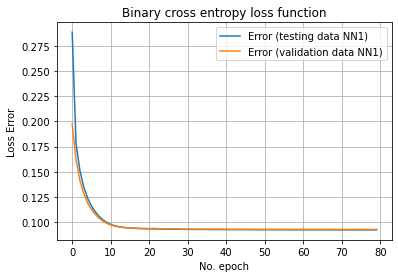

In [11]:

plt.plot(logsNN1.history['loss'], label='Error (testing data NN1)')
plt.plot(logsNN1.history['val_loss'], label='Error (validation data NN1)')
plt.title('Binary cross entropy loss function')
plt.ylabel('Loss Error')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

plt.grid()

> What is the number of trained parameters of this auto-encoder ?

> is it supervised or unsupervised learning ?

> What is the compression ratio enabled by this auto-encoder ? 

> Test the deep auto-encoder on testing set.

> Display the ten first images (original and decoded).





In [12]:
encoded_imgs = encoder.predict(training_set.X_test)
decoded_imgs = decoder.predict(encoded_imgs)
# you can also use 
decoded_imgs = autoencoder.predict(training_set.X_test); 

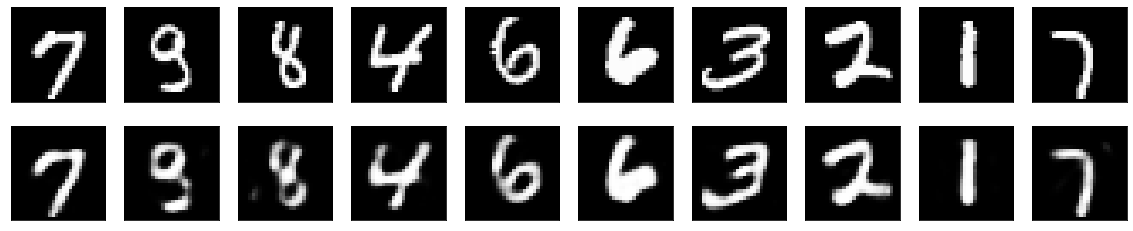

In [13]:
def plotDigits(n, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(training_set.X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

plotDigits(10, decoded_imgs)

> you can also print the outputs of the encoder encoded_imgs (latent variables) of the ten first digits 

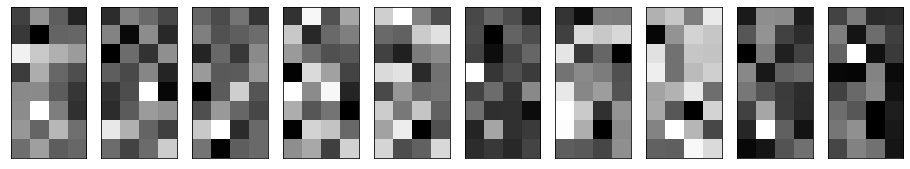

In [14]:
n = 10  # how many digits we will display
plt.figure(figsize=(16, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 5.b - Build a deep auto-encoder with three dense layer

> Define a deep auto-encoder with three dense layers of size: 128, 64, 32.


In [15]:
original_dim = 784
intermediate_dim0 = 128
intermediate_dim1 = 64
latent_dim = 32

# TO DO
input_img = Input(shape=(original_dim,))

encoder_layer0 = Dense(intermediate_dim0, activation='elu')
encoded0 = encoder_layer0(input_img)

encoder_layer1 = Dense(intermediate_dim1, activation='elu')
encoded1 = encoder_layer1(encoded0)

encoder_layer = Dense(latent_dim, activation='elu')
encoded = encoder_layer(encoded1)

decoder_layer1 = Dense(intermediate_dim1, activation='sigmoid') 
decoded1 = decoder_layer1(encoded)

decoder_layer0 = Dense(intermediate_dim0, activation='sigmoid') 
decoded0 = decoder_layer0(decoded1)

decoder_layer = Dense(original_dim, activation='sigmoid') 
decoded = decoder_layer(decoded0)

autoencoderNN3 = Model(input_img, decoded)
autoencoderNN3.compile(optimizer='adam', loss='binary_crossentropy') # you can also use MSE loss function 

autoencoder.summary()


logsNN3 = autoencoderNN3.fit(training_set.X_train, training_set.X_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(training_set.X_test, training_set.X_test))


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
206/206 [==============================] - 3s 10ms/step - loss: 0.3597 - val_loss: 0.2628
Epoch 2/80
206/206 [==============================] - 2s 9ms/step - loss: 0.2615 - val_loss: 0.2467
Epoch 3/80
206/206 [==============================] - 2s 9ms/step - loss: 0.2440 - val_loss: 0.2357
Epoch 4/80
206/206 [==============================] - 2s 9ms/step - loss: 0.2310 - val

206/206 [==============================] - 2s 9ms/step - loss: 0.0901 - val_loss: 0.0909
Epoch 75/80
206/206 [==============================] - 2s 8ms/step - loss: 0.0897 - val_loss: 0.0916
Epoch 76/80
206/206 [==============================] - 2s 8ms/step - loss: 0.0898 - val_loss: 0.0915
Epoch 77/80
206/206 [==============================] - 2s 9ms/step - loss: 0.0896 - val_loss: 0.0917
Epoch 78/80
206/206 [==============================] - 2s 10ms/step - loss: 0.0895 - val_loss: 0.0902
Epoch 79/80
206/206 [==============================] - 2s 8ms/step - loss: 0.0892 - val_loss: 0.0902
Epoch 80/80
206/206 [==============================] - 2s 9ms/step - loss: 0.0892 - val_loss: 0.0899


> Draw the evolution of the loss function during the training on training set and testing set 

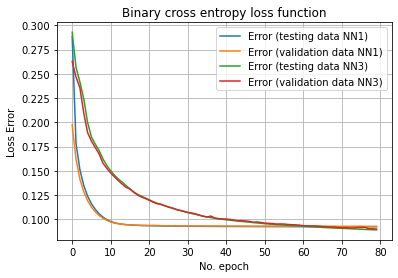

In [16]:
plt.plot(logsNN1.history['loss'], label='Error (testing data NN1)')
plt.plot(logsNN1.history['val_loss'], label='Error (validation data NN1)')
plt.plot(logsNN3.history['loss'], label='Error (testing data NN3)')
plt.plot(logsNN3.history['val_loss'], label='Error (validation data NN3)')
plt.title('Binary cross entropy loss function')
plt.ylabel('Loss Error')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.grid()
plt.show()


> What is the number of trained parameters of this auto-encoder.

> What is the compression ration enabled by this auto-encoder. 

> Test the deep auto-encoder on testing set 

> Display the ten first image (original and decoded).

 

 

In [17]:
decoded_imgsNN3 = autoencoderNN3.predict(training_set.X_test)

> Print the ten first images in testing set with the decoded onces.

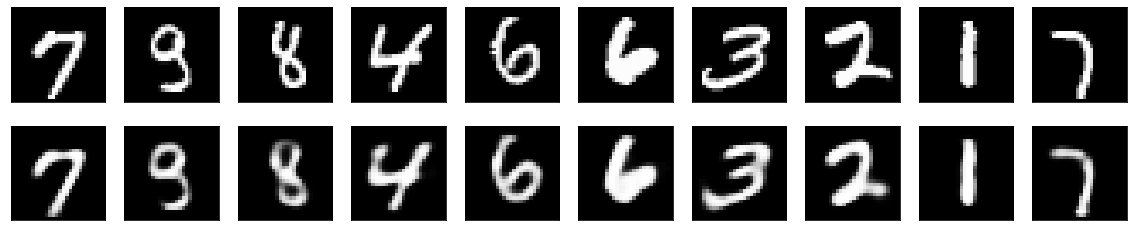

In [18]:
plotDigits(10, decoded_imgsNN3)

### 5.c - Build a deep auto-encoder with only conv layers

> Define a deep auto-encoder with two conv layers both composed of 32 features and kernel of size (3,3) followed by MaxPooling2D((2, 2), padding='same') (/2) for encoder and UpSampling2D((2, 2)) (*2) for the decoder.  Add last layer with 1 feature, (3,3) kernel and a sigmoid activation function.  

In [22]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

training_set.reshapeinImage()

# TO DO
input_img = Input(shape=(28, 28, 1))

autoencoderConv = Sequential()
autoencoderConv.add(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same', input_shape=(28,28,1)))
autoencoderConv.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
autoencoderConv.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoderConv.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
autoencoderConv.add(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same'))
autoencoderConv.add(UpSampling2D((2, 2)))
autoencoderConv.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoderConv.add(UpSampling2D((2, 2)))
autoencoderConv.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoderConv.compile(optimizer='adam', loss='binary_crossentropy')

autoencoderConv.summary()


logsConv = autoencoderConv.fit(training_set.X_trainIm, training_set.X_trainIm,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(training_set.X_testIm, training_set.X_testIm))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)       

206/206 [==============================] - 54s 261ms/step - loss: 0.0637 - val_loss: 0.0637
Epoch 66/80
206/206 [==============================] - 53s 258ms/step - loss: 0.0638 - val_loss: 0.0638
Epoch 67/80
206/206 [==============================] - 54s 260ms/step - loss: 0.0637 - val_loss: 0.0637
Epoch 68/80
206/206 [==============================] - 54s 260ms/step - loss: 0.0636 - val_loss: 0.0637
Epoch 69/80
206/206 [==============================] - 54s 264ms/step - loss: 0.0635 - val_loss: 0.0637
Epoch 70/80
206/206 [==============================] - 53s 258ms/step - loss: 0.0636 - val_loss: 0.0636
Epoch 71/80
206/206 [==============================] - 54s 261ms/step - loss: 0.0635 - val_loss: 0.0636
Epoch 72/80
206/206 [==============================] - 55s 265ms/step - loss: 0.0635 - val_loss: 0.0637
Epoch 73/80
206/206 [==============================] - 54s 262ms/step - loss: 0.0634 - val_loss: 0.0636
Epoch 74/80
206/206 [==============================] - 53s 259ms/step - loss

> Print the evolution of the loss function during the training on training set and testing set 

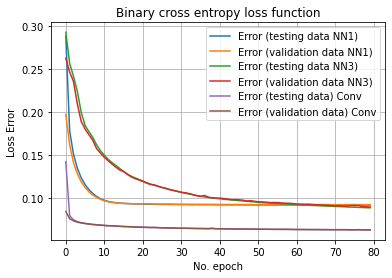

In [23]:
plt.plot(logsNN1.history['loss'], label='Error (testing data NN1)')
plt.plot(logsNN1.history['val_loss'], label='Error (validation data NN1)')
plt.plot(logsNN3.history['loss'], label='Error (testing data NN3)')
plt.plot(logsNN3.history['val_loss'], label='Error (validation data NN3)')
plt.plot(logsConv.history['loss'], label='Error (testing data) Conv')
plt.plot(logsConv.history['val_loss'], label='Error (validation data) Conv')
plt.title('Binary cross entropy loss function')
plt.ylabel('Loss Error')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.grid()
plt.show()

> Test the Conv auto-encoder on testing set.


In [24]:
decoded_imgsConv = autoencoderConv.predict(training_set.X_testIm)

> Print the ten first images in testing set with the decoded onces.

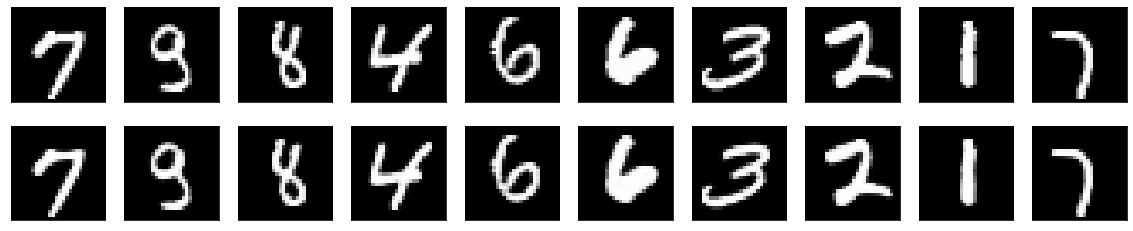

In [25]:
plotDigits(10, decoded_imgsConv)

> What do you think about the quality of the reconstructed images, compare with those of previous auto-encoders 

## 6- Application to image denoising

> Add noise to the testing sets and try to denoise with the prevous auto-encoder




In [26]:
Noiseintensity = 0.5;
training_set.adddNoise(Noiseintensity);
# Denoise training_set.X_testIm_noisy
decoded_imgsNoise = autoencoderConv.predict(training_set.X_testIm_noisy)

> Illustrate the 10 images before and after denoising process

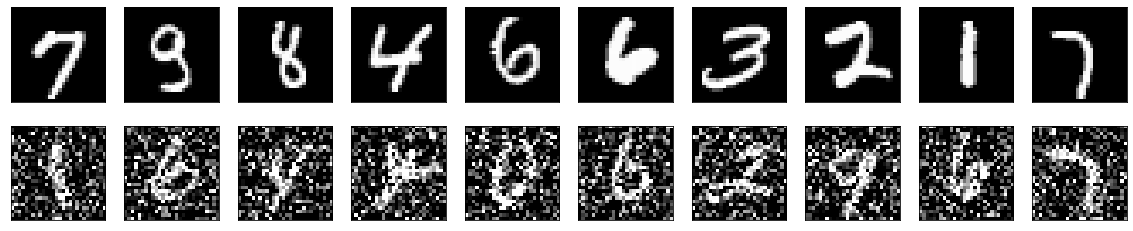

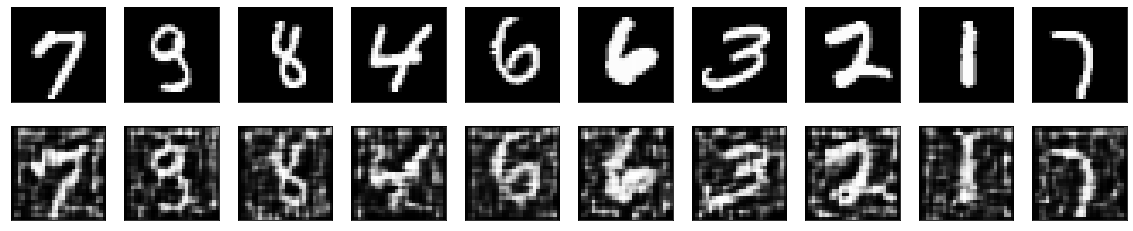

In [28]:
plotDigits(10, training_set.X_trainIm_noisy)
plotDigits(10, decoded_imgsNoise)

> Now, you can define and train the last auto-encoder to perform denoising

In [30]:

# TO DO
# Define the conv auto-encoder model and train it for denoising

input_img = Input(shape=(28, 28, 1))

autoencoderConvDenoise = Sequential()
autoencoderConvDenoise.add(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same', input_shape=(28,28,1)))
autoencoderConvDenoise.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
autoencoderConvDenoise.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoderConvDenoise.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
autoencoderConvDenoise.add(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same'))
autoencoderConvDenoise.add(UpSampling2D((2, 2)))
autoencoderConvDenoise.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoderConvDenoise.add(UpSampling2D((2, 2)))
autoencoderConvDenoise.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoderConvDenoise.compile(optimizer='adam', loss='binary_crossentropy')

autoencoderConvDenoise.summary()


logsconvDen = autoencoderConvDenoise.fit(training_set.X_trainIm_noisy, training_set.X_trainIm,
                epochs=15,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(training_set.X_testIm_noisy, training_set.X_testIm))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 32)       

> Denoise the testing set 



In [31]:
decoded_imgsConvNoise = autoencoderConvDenoise.predict(training_set.X_testIm_noisy)

> Illustrate the 10 images before and after denoising process

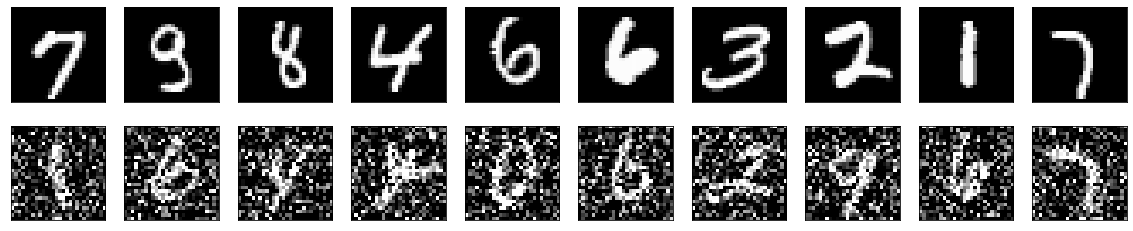

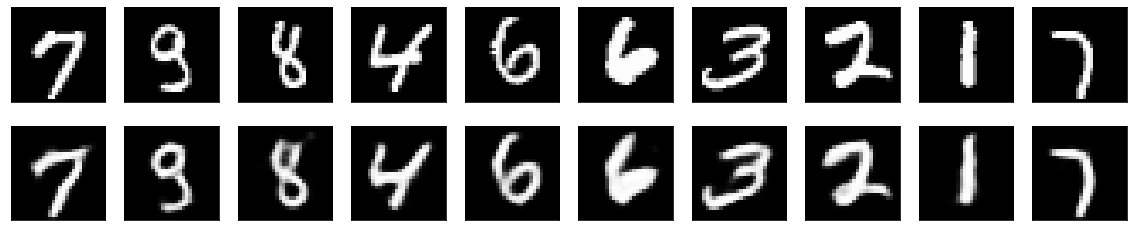

In [32]:
plotDigits(10, training_set.X_trainIm_noisy)
plotDigits(10, decoded_imgsConvNoise)

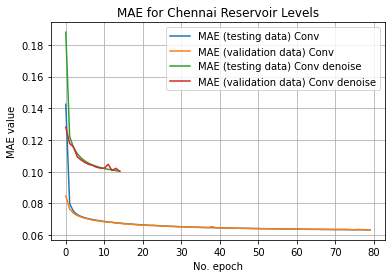

In [33]:
plt.plot(logsConv.history['loss'], label='MAE (testing data) Conv')
plt.plot(logsConv.history['val_loss'], label='MAE (validation data) Conv')
plt.plot(logsconvDen.history['loss'], label='MAE (testing data) Conv denoise')
plt.plot(logsconvDen.history['val_loss'], label='MAE (validation data) Conv denoise')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

plt.grid()
plt.show()

## 7- Variational auto-encoder (VAE)

> In this section you will build a variational auto-encoder with two dense layers

> 

In [43]:
original_dim = 784
intermediate_dim = 64
latent_dim = 32

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name='encoder_input')
x = layers.Dense(intermediate_dim, activation='elu')(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
#TO DO 

decoded1 = layers.Dense(intermediate_dim, activation='sigmoid')(z)
decoded2 = layers.Dense(original_dim, activation='sigmoid')(decoded1)

autoencoderVar = Model(original_inputs, decoded2)

decoder_layer1 = autoencoderVar.layers[-2]
decoder_layer2 = autoencoderVar.layers[-1]

encoded_input = Input(shape=(latent_dim,))
decoder = Model(encoded_input, decoder_layer2(decoder_layer1(encoded_input)))

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name='vae')

# Add KL divergence regularization loss.
kl_loss = - 0.5 * tf.reduce_mean(
    z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

# Train.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.summary()

vae.fit(training_set.X_train, training_set.X_train, epochs=20, batch_size=128)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________

> Denerate new digits with the generative decoder

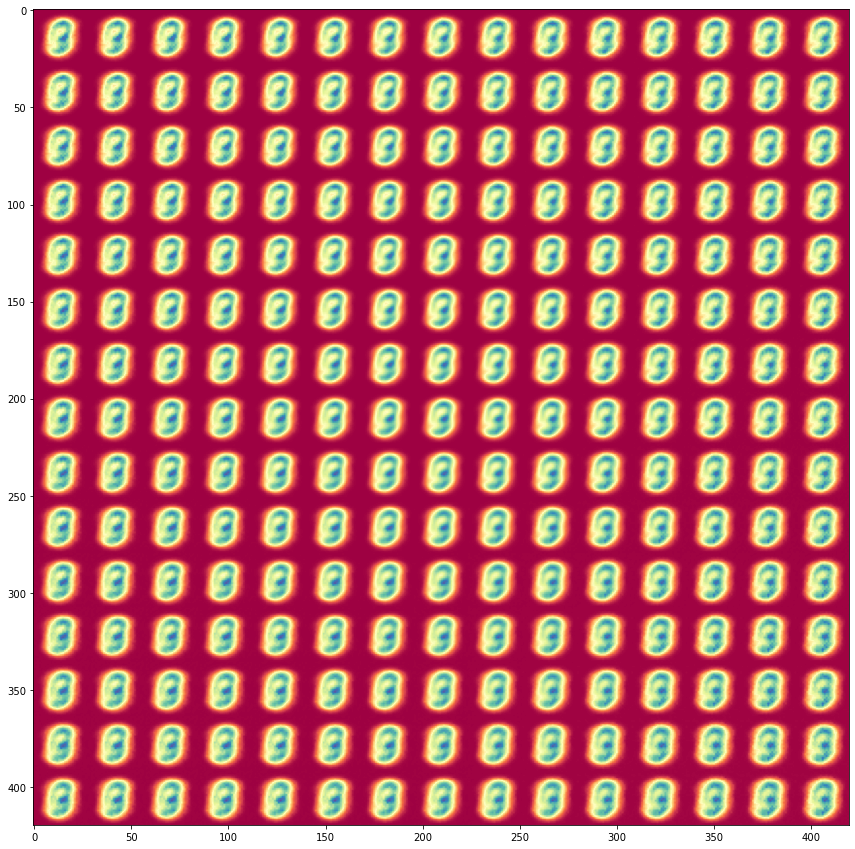

In [41]:
n = 15  # how many digits we will display
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)[::-1]

epsilon   = K.random_normal(shape=(1, 32))
for  i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
   
    z_sample  = np.array([[xi, yi]*16]) * epsilon
    x_decoded = decoder.predict(z_sample)
    digit     = x_decoded.reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Spectral')